In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyDOE
from invertH import *
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});


<IPython.core.display.Javascript object>

## Ball Drop with Varying Radii
Consider dropping balls of various radii $R$ from a tower at heights 5, 10, 15, and 20 meters. Each dropped ball experiment produces vector output in the form of a height-time curve, i.e., a curve showing the time as a function of the current height $t=t(h)$ of the ball at a set of defined heights $h$.

We will generate synthetic experimental data from:
\begin{equation}
\frac{d^2h}{dt^2} = g - \frac{C}{R}\bigg(\frac{dh}{dt}\bigg)^2
\end{equation}
where $g$ is the acceleration due to gravity, $C$ is the coefficient of drag, and R is the radius of the ball. We will refer to data generated from equation (1) as system observations. To illustrate the modeling of discrepency between simulator and reality, we will generate simulated data from:
\begin{equation}
\frac{d^2h}{dt^2} = g - \frac{C}{R}\frac{dh}{dt}
\end{equation}
Note the simulated data will be systematically biased from the experimental data as it is generated with a linear velocity term $(dh/dt)$ rather than a squared velocity term. We will explicitly model this discrepecy.

These differential equations can be solved for height $h$ as a function of time $t$, ball radius $R$, and drag $C$. Observations will be the inverse: time recorded as a function of height, radius, and drag calculated by an optimizer from the scipy library in Python.

Acceleration due to gravity $g$ is assumed to be known, but the coefficient of drag $C$ is not, and is the target of inference. That is, the goal is to find the posterior distribution of $C$ that corresponds to the Sepia statistical model fit to all available data.

The first step is to compute system observations from (1) and simulated data from (2). As is standard practice in the study of computer codes a (space-filling) Latin hypercube (LH) design is used to effieintly collect simulator data over the domain of model parameters, in this case $(R,C)$.

Suppose we have data from $n=3$ experiments, one each for balls of radius $R={0.1,0.2,0.4}$ meters. Each experiment produces a curve of drop times made of three or four height-time pairs. For the two smallest balls, the experimental heights are $h_e={5,10,15,20}$ meters. The largest has a drop time measured at only from experimental heights $h_e={5,10,15}$ meters. For the experimental data we use assume the observation error is zero mean and normally distributed and fix $C=0.1*4\pi/3$, the coefficient of drag for a sphere.

In [4]:
n = 3                          # numer of experiements
g = 9.8                        # gravity
et = 0.01                       # observation error
C_true = 0.1 / (4 * np.pi / 3) # coefficient of drag
R = np.array([0.1,0.2,0.4])

h_field = np.linspace(5,20,4)
t_field       = invertHtrue(h_field, g, C_true, R, et) # observed times
t_field[-1,-1] = np.nan # largest ball not dropped from 20m

We compute experimental data on a dense grid and plot the noisy data below.

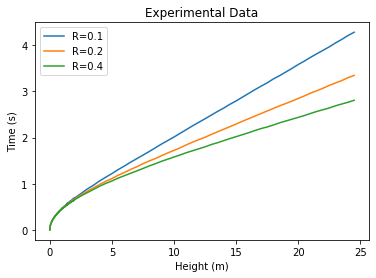

In [5]:
h_dense = np.concatenate((np.arange(0,2,.01),np.arange(2,25,.5)))
t_field_dense = invertHtrue(h_dense, g, C_true, R, et)
for i in range(n):
    plt.plot(h_dense,t_field_dense[i,:],label="R={}".format(R[i]))
plt.xlabel('Height (m)');plt.ylabel("Time (s)");plt.title("Experimental Data")
plt.legend()

For simulated data inputs, we use a scaled latin hypercube design to select $m=25\;(R,C)$ pairs. We then scale the design so $R\in[0.05,0.45]$ and $C\in[0.05,0.25]$. The simulator will be run at these 25 design points and will return times for 16 evenly spaced heights between 1.5 and 25 meters.

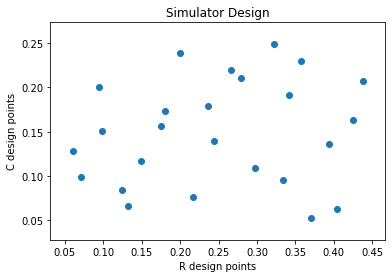

In [6]:
m=25
sim_design = pyDOE.lhs(2,m)
R_sim = sim_design[:,0] * .4 + .05
C_sim = sim_design[:,1] * .2 + .05
plt.scatter(R_sim,C_sim)
plt.xlabel("R design points");plt.ylabel("C design points")
plt.title("Simulator Design")
plt.show()

Text(0.5, 1.0, 'Simulator Output for m=25 (R,C) Pairs')

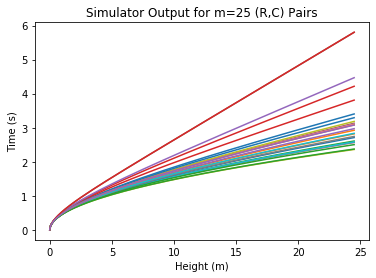

In [7]:
# Compute simulated data
h_sim = h_sim = np.arange(1.5,25,1.5)
t_sim  = invertHsim(h_sim, g, C_sim, R_sim)

# plot on dense grid
t_sim_dense = invertHsim(h_dense, g, C_sim, R_sim)
for i in range(m): plt.plot(h_dense,t_sim_dense[i,:])
plt.xlabel('Height (m)'); plt.ylabel("Time (s)")
plt.title("Simulator Output for m=25 (R,C) Pairs")

See invertH.py for details on solving and inverting equations (1) and (2). Below we show, for each Radius R, the physical reality, defined by equation (1), the noisy observations, and all 25 simulation realizations. For each R, the 3 simulations with design points nearest to R are shown as red, green, and blue lines.

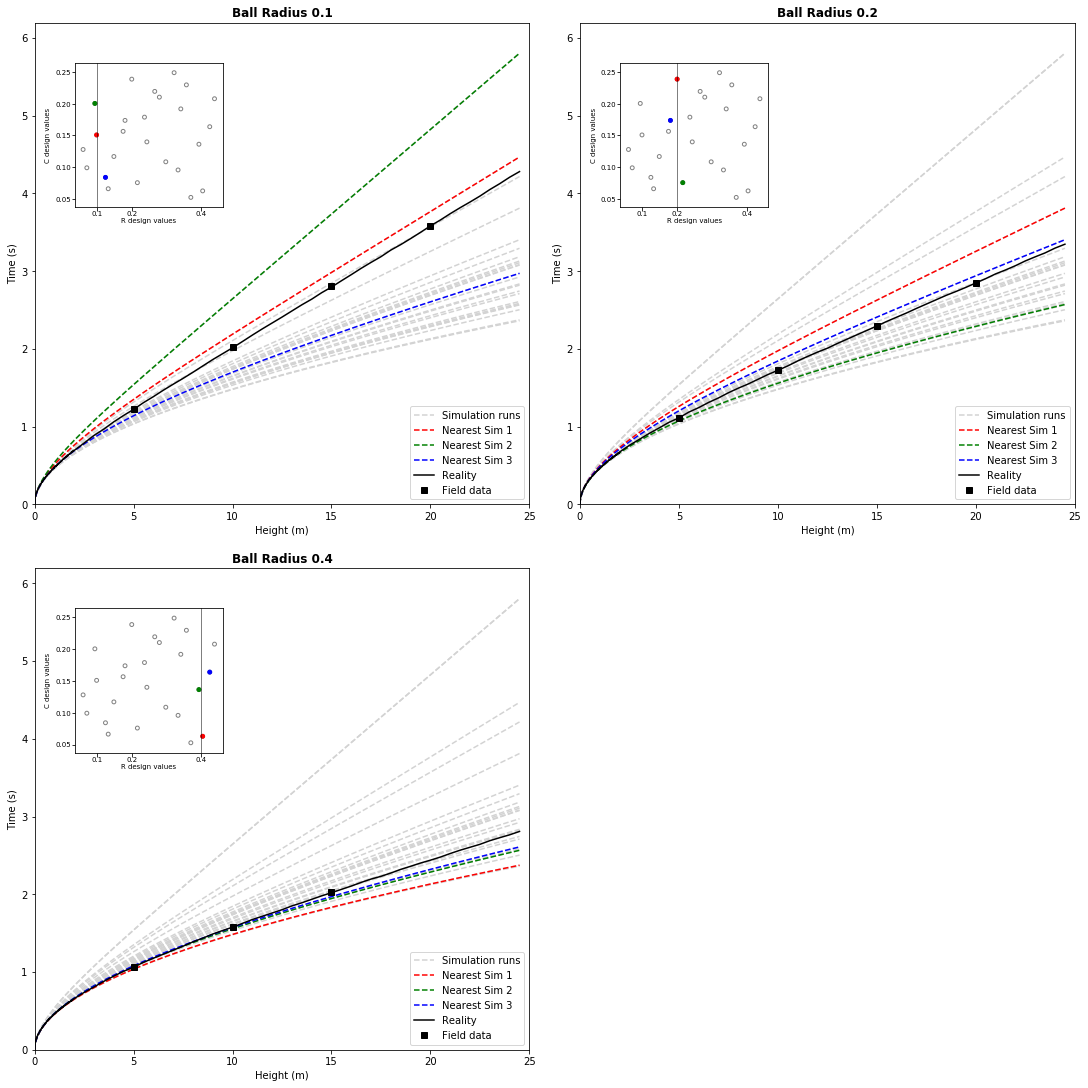

In [8]:
y_max = max(max(t_field.max(1)),max(t_sim.max(1))) # max of all row maxes for axis limit
# find closest values each R
# ith column of R_nearest_des contains the n_neighbors nearest design points (by index)
# for ith value of R
n_neighbors = 3
R_nearest_des = np.zeros(shape=(n_neighbors,len(R)),dtype=int)
for i in range(len(R)):
    dist = np.argsort(np.abs(R_sim-R[i]))
    R_nearest_des[:,i] = dist[0:n_neighbors]
    
# Generate plot for each radius
colors = ('r', 'g', 'b')
#fig, axs = plt.subplots(2,2)
#axs = axs.flatten()
fig = plt.figure(figsize=[15,15],constrained_layout=True)
gs = GridSpec(2,2,figure=fig)
axs = np.array([fig.add_subplot(gs[0,0]),\
                fig.add_subplot(gs[0,1]),\
                fig.add_subplot(gs[1,0])])
for i in range(len(R)):
    # axis limits, ticks, and labels
    axs[i].set_xlim([0, 25])
    axs[i].set_ylim([0, y_max+.5])
    axs[i].xaxis.set_ticks(np.arange(0,30,5))
    axs[i].yaxis.set_ticks(np.arange(0,y_max+.5,1))
    axs[i].set_title("Ball Radius {}".format(R[i]),fontweight="bold")
    axs[i].set_xlabel("Height (m)")
    axs[i].set_ylabel("Time (s)")
    
    # simulations - all
    for j in range(m):
        axs[i].plot(h_dense, np.transpose(t_sim_dense)[:,j],color='lightgrey',\
                linestyle="--",label="Simulation runs" if j==0 else "")
    
    # simulations - nearest neighbors
    for j in range(n_neighbors):
        axs[i].plot(h_dense,np.transpose(t_sim_dense)[:,R_nearest_des[j,i]],\
                    linestyle="--",\
                    color=colors[j],label="Nearest Sim {}".format(j+1))
    
    # true data curve and "real data points"
    axs[i].plot(h_dense, t_field_dense[i,:],'k',label="Reality")
    axs[i].plot(h_field, t_field[i,],'ks',label="Field data")
    

    axs[i].legend(loc="lower right")
    

        
    # imbed design point subplot
    inset_ax = inset_axes(axs[i],width="30%",height="30%",loc="upper left",\
                          borderpad=4)
    inset_ax.set_xlabel("R design values",fontsize=7,labelpad=1)
    inset_ax.set_ylabel("C design values",fontsize=7)
    inset_ax.xaxis.set_ticks(R)
    inset_ax.yaxis.set_ticks(np.arange(0,.251,.05))
    inset_ax.tick_params(axis='both', which='major', labelsize=7, pad = 0)
    inset_ax.scatter(R_sim,C_sim,s=15, facecolors='none', edgecolors='grey')
    inset_ax.scatter(R_sim[R_nearest_des[:,i]],C_sim[R_nearest_des[:,i]],s=15,\
                     color=colors)
    inset_ax.axvline(x=R[i], ymin=0, ymax=1,color='k',linewidth=.5)